# Model Evaluation — Intent Classifier & CRF Entity Tagger

This notebook evaluates:
- Intent classifier (Logistic Regression)
- CRF entity recognizer (BIO tagging)

Metrics:
- Accuracy
- Precision / Recall / F1-score
- Confusion matrix
- Example predictions


In [1]:
import json
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

try:
    from sklearn_crfsuite import metrics as crf_metrics
except:
    crf_metrics = None
    print("CRF metrics unavailable")

ROOT = Path.cwd().parents[0]  # notebook in notebooks/ so parent=project root
DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
REPORTS_DIR = ROOT / "reports"
REPORTS_DIR.mkdir(exist_ok=True)

ROOT, DATA_DIR, MODELS_DIR, REPORTS_DIR


Matplotlib is building the font cache; this may take a moment.


(WindowsPath('c:/Users/Administrator/travel-rule-project'),
 WindowsPath('c:/Users/Administrator/travel-rule-project/data'),
 WindowsPath('c:/Users/Administrator/travel-rule-project/models'),
 WindowsPath('c:/Users/Administrator/travel-rule-project/reports'))

In [2]:
intent_model_path = MODELS_DIR / "intent_clf.pkl"
intent_pipe = joblib.load(intent_model_path)

# load natural-language rules for evaluation
texts = []
labels = []
with open(DATA_DIR / "generated_rules.jsonl", encoding="utf8") as fh:
    for line in fh:
        obj = json.loads(line)
        texts.append(obj["nl"])
        labels.append(obj["name"])

len(texts)


1000

                              precision    recall  f1-score   support

          blackout_exclusion       1.00      1.00      1.00        11
  blackout_min_stay_conflict       1.00      1.00      1.00         9
     booking_window_discount       1.00      1.00      1.00         7
       bundle_combo_discount       1.00      1.00      1.00        12
         cancellation_policy       1.00      1.00      1.00        11
        child_infant_pricing       0.00      0.00      0.00         9
      group_booking_discount       0.20      0.09      0.12        11
       insurance_requirement       0.19      0.70      0.30        10
            loyalty_discount       1.00      1.00      1.00        10
             manual_override       1.00      0.11      0.20         9
               min_stay_perk       1.00      1.00      1.00         9
    payment_method_incentive       0.20      0.10      0.13        10
          price_match_policy       1.00      1.00      1.00        11
      product_class

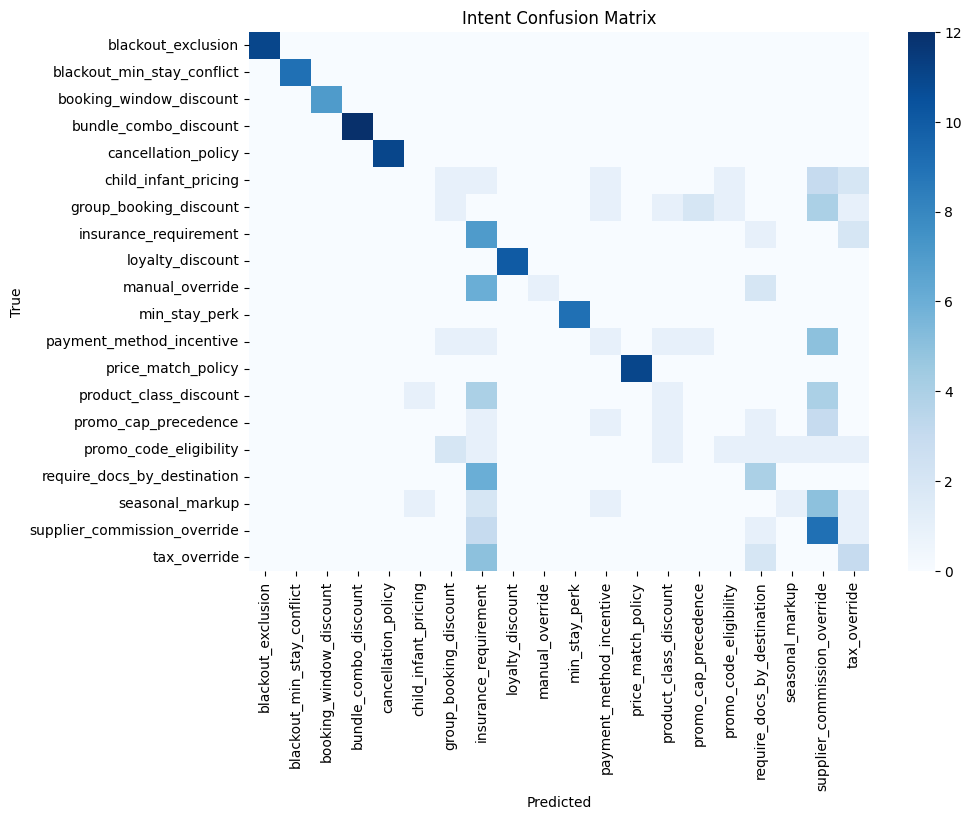

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

y_pred = intent_pipe.predict(X_test)

report = classification_report(y_test, y_pred, zero_division=0)
print(report)

with open(REPORTS_DIR / "metrics_intent.txt", "w", encoding="utf8") as f:
    f.write(report)

# confusion matrix
labels_unique = sorted(list(set(labels)))
cm = confusion_matrix(y_test, y_pred, labels=labels_unique)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=labels_unique, yticklabels=labels_unique)
plt.title("Intent Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [4]:
import random

for _ in range(5):
    i = random.randint(0, len(X_test)-1)
    print("TEXT:", X_test[i])
    print("TRUE INTENT:", y_test[i])
    print("PRED INTENT:", y_pred[i])
    print("-" * 70)


TEXT: apply 8% discount on flight when conditions match.
TRUE INTENT: payment_method_incentive
PRED INTENT: supplier_commission_override
----------------------------------------------------------------------
TEXT: No discounts available for stays that include 2025-12-24, 2025-12-31.
TRUE INTENT: blackout_exclusion
PRED INTENT: blackout_exclusion
----------------------------------------------------------------------
TEXT: If competitor price is lower: we will give to match competitor price if proof is provided within 12 hours.
TRUE INTENT: price_match_policy
PRED INTENT: price_match_policy
----------------------------------------------------------------------
TEXT: If stay is 3 nights or more, include free breakfast with the hotel booking.
TRUE INTENT: min_stay_perk
PRED INTENT: min_stay_perk
----------------------------------------------------------------------
TEXT: No discounts available for stays that include 2025-12-24, 2025-12-31.
TRUE INTENT: blackout_exclusion
PRED INTENT: black

In [5]:
bio_items = [json.loads(l) for l in open(DATA_DIR / "bio_training_data.jsonl", "r", encoding="utf8")]

def word2features(sent, i):
    w = sent[i]
    return {
        "word.lower()": w.lower(),
        "isupper": w.isupper(),
        "istitle": w.istitle(),
        "isdigit": w.isdigit(),
    }

def sent2features(sent): return [word2features(sent, i) for i in range(len(sent))]

X = [sent2features(item["tokens"]) for item in bio_items]
y = [item["tags"] for item in bio_items]

len(X), len(y)


(1000, 1000)

In [6]:
crf_model_path = MODELS_DIR / "crf_model.pkl"
crf = joblib.load(crf_model_path)

y_pred = crf.predict(X)

if crf_metrics:
    report_crf = crf_metrics.flat_classification_report(y, y_pred)
    print(report_crf)
    with open(REPORTS_DIR / "metrics_crf.txt", "w", encoding="utf8") as f:
        f.write(report_crf)
else:
    print("CRF metrics unavailable")


                precision    recall  f1-score   support

        B-DATE       0.00      0.00      0.00       186
B-DISCOUNT_PCT       0.00      0.00      0.00       804
         B-ORG       0.00      0.00      0.00        12
        B-TIME       0.00      0.00      0.00        52
        I-DATE       0.05      1.00      0.10       559
I-DISCOUNT_PCT       0.00      0.00      0.00       804
        I-TIME       0.00      0.00      0.00        52
             O       0.00      0.00      0.00      9439

      accuracy                           0.05     11908
     macro avg       0.01      0.12      0.01     11908
  weighted avg       0.00      0.05      0.00     11908



c:\Users\Administrator\travel-rule-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Administrator\travel-rule-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Administrator\travel-rule-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

In [7]:
for i in range(5):
    print("TOKENS:", bio_items[i]["tokens"])
    print("TRUE :", bio_items[i]["tags"])
    print("PRED :", y_pred[i])
    print("-" * 70)


TOKENS: ['apply', '5', '%', 'discount', 'on', 'visa', 'when', 'conditions', 'match', '.']
TRUE : ['O', 'B-DISCOUNT_PCT', 'I-DISCOUNT_PCT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
PRED : ['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE']
----------------------------------------------------------------------
TOKENS: ['No', 'discounts', 'available', 'for', 'stays', 'that', 'include', 'dates', '.']
TRUE : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
PRED : ['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE']
----------------------------------------------------------------------
TOKENS: ['apply', '10', '%', 'off', 'on', 'visa', 'when', 'conditions', 'match', '.']
TRUE : ['O', 'B-DISCOUNT_PCT', 'I-DISCOUNT_PCT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
PRED : ['B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE']
---------------------------------------------------------

# Evaluation Summary

- Intent classifier metrics are stored in `reports/metrics_intent.txt`
- CRF entity extractor metrics stored in `reports/metrics_crf.txt`
- Confusion matrix shown above
- Sample predictions shown for both models

This completes the evaluation component of the project.
